In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
# from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans # For initialization comparison

class StandardScalerNumPy:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit_transform(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        # Add epsilon to avoid division by zero
        self.std[self.std == 0] = 1e-8
        return (X - self.mean) / self.std

    def inverse_transform(self, X_scaled):
        return (X_scaled * self.std) + self.mean

# 1. Load Data
data = load_breast_cancer()
X = data.data
y_true = data.target
feature_names = data.feature_names

# 2. Standardize
scaler = StandardScalerNumPy()
X_scaled = scaler.fit_transform(X)



In [14]:
import os
print(os.getcwd())


z:\Downloads\College\Term 7\Machine Learning Practicing\Group Assignment 4\PCA-Autoencoder-KMeans-GMM


In [15]:
# 3. Load External Notebooks
# This makes the 'GMM' class and metric functions available
%run ./GMM.ipynb
%run ./metrics.ipynb

print(f"Data Loaded: {X_scaled.shape}")
print("GMM Class and Metrics loaded.")

GMM Class initialized.
Data Loaded: (569, 30)
GMM Class and Metrics loaded.


In [16]:
# --- MONKEY PATCHING: Add K-Means Initialization Support ---

def _initialize_parameters_extended(self, X):
    n_samples, n_features = X.shape
    
    # Check if 'kmeans' init is requested
    if hasattr(self, 'init_params') and self.init_params == 'kmeans':
        # 1. Run K-Means
        km = KMeans(n_clusters=self.n_components, n_init=1, random_state=42)
        km.fit(X)
        
        # 2. Use Centroids as Means
        self.means_ = km.cluster_centers_
        self.weights_ = np.ones(self.n_components) / self.n_components
        
        # 3. Estimate Covariance
        labels = km.labels_
        avg_cov = np.cov(X.T) + np.eye(n_features) * self.reg_covar
        
        if self.covariance_type == 'full':
            self.covariances_ = np.array([
                np.cov(X[labels == k].T) + np.eye(n_features)*self.reg_covar 
                if np.sum(labels==k) > 1 else avg_cov
                for k in range(self.n_components)
            ])
        else:
             # Fallback for non-full types (reuse helper)
             self._init_standard_cov(X)
             
    else:
        # Fallback to Original Random Init
        rng = np.random.default_rng(42)
        random_indices = rng.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[random_indices]
        self.weights_ = np.full(self.n_components, 1 / self.n_components)
        self._init_standard_cov(X)

# Helper for covariance init (extracted from your original code)
def _init_standard_cov(self, X):
    n_features = X.shape[1]
    avg_cov = np.cov(X.T) + np.eye(n_features) * self.reg_covar
    
    if self.covariance_type == 'full':
        self.covariances_ = np.array([avg_cov for _ in range(self.n_components)])
    elif self.covariance_type == 'tied':
        self.covariances_ = avg_cov
    elif self.covariance_type == 'diagonal':
        self.covariances_ = np.array([np.diag(avg_cov) for _ in range(self.n_components)])
    elif self.covariance_type == 'spherical':
        self.covariances_ = np.full(self.n_components, np.mean(np.diag(avg_cov)))

# Apply the patch to the class
GMM._initialize_parameters = _initialize_parameters_extended
GMM._init_standard_cov = _init_standard_cov

print("GMM Class successfully patched to support K-Means Initialization.")

GMM Class successfully patched to support K-Means Initialization.


In [21]:
covariance_types = ['full', 'tied', 'diagonal', 'spherical']
k_range = range(2, 11)

results = []
best_bic = np.inf
best_model = None
best_config = {}

print("Starting Grid Search...")

for cov_type in covariance_types:
    for k in k_range:
        # Train
        gmm = GMM(n_components=k, covariance_type=cov_type, max_iter=100, tol=1e-4)
        gmm.fit(X_scaled)
        
        # Score
        bic = gmm.bic(X_scaled)
        aic = gmm.aic(X_scaled)
        
        results.append({
            'cov': cov_type,
            'k': k,
            'bic': bic,
            'aic': aic
        })
        
        if bic < best_bic:
            best_bic = bic
            best_model = gmm
            best_config = {'cov': cov_type, 'k': k}

print(f"Best Configuration Found: K={best_config['k']}, Type={best_config['cov']}, BIC={best_bic:.2f}")

Starting Grid Search...
Best Configuration Found: K=4, Type=full, BIC=8359.76


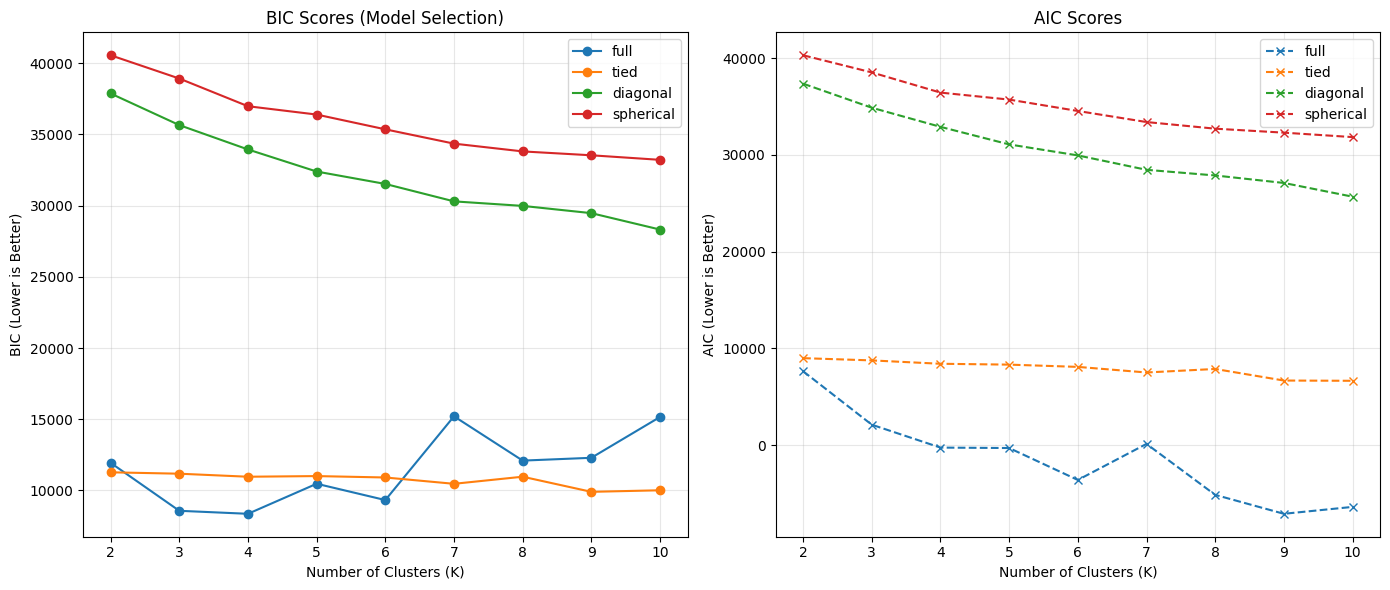

In [18]:
# Organize data for plotting
bic_data = {ctype: [] for ctype in covariance_types}
aic_data = {ctype: [] for ctype in covariance_types}

for res in results:
    bic_data[res['cov']].append(res['bic'])
    aic_data[res['cov']].append(res['aic'])

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for ctype in covariance_types:
    plt.plot(k_range, bic_data[ctype], marker='o', label=ctype)
plt.title('BIC Scores (Model Selection)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('BIC (Lower is Better)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for ctype in covariance_types:
    plt.plot(k_range, aic_data[ctype], marker='x', linestyle='--', label=ctype)
plt.title('AIC Scores')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('AIC (Lower is Better)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Comparing Initialization Strategies for K=4, Type=full...


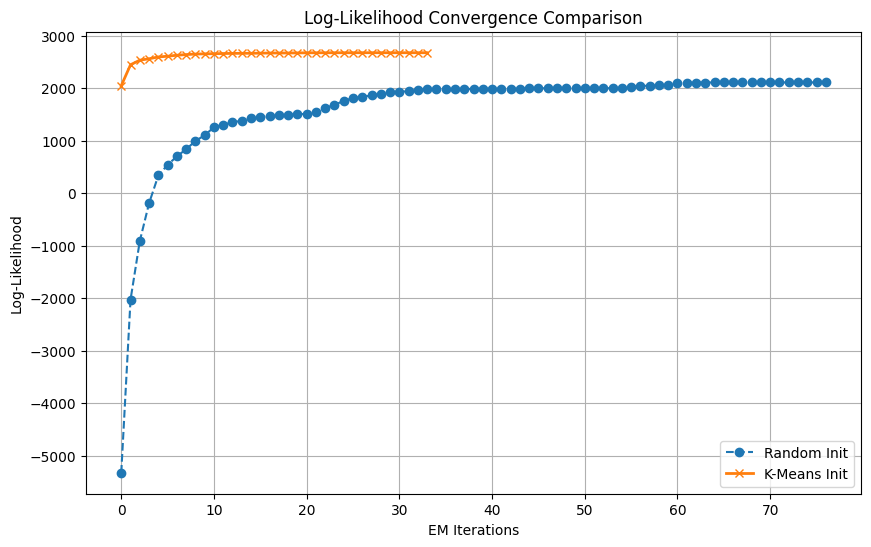

Iterations to Converge (Random): 77
Iterations to Converge (K-Means): 34


In [ ]:
# Configuration from best model (or manual override)
k_eval = best_config['k']
cov_eval = best_config['cov']

print(f"Comparing Initialization Strategies for K={k_eval}, Type={cov_eval}...")

# 1. Random Init
gmm_random = GMM(n_components=k_eval, covariance_type=cov_eval, max_iter=100)
gmm_random.init_params = 'random' # Default
gmm_random.fit(X_scaled)

# 2. K-Means Init
gmm_kmeans = GMM(n_components=k_eval, covariance_type=cov_eval, max_iter=100)
gmm_kmeans.init_params = 'kmeans' # Uses the monkey patch
gmm_kmeans.fit(X_scaled)

# 3. Plot Convergence
plt.figure(figsize=(10, 6))
plt.plot(gmm_random.log_likelihood_history_, label='Random Init', linestyle='--', marker='o')
plt.plot(gmm_kmeans.log_likelihood_history_, label='K-Means Init', linewidth=2, marker='x')
plt.title('Log-Likelihood Convergence Comparison')
plt.xlabel('EM Iterations')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.grid(True)
plt.show()

print(f"Iterations to Converge (Random): {len(gmm_random.log_likelihood_history_)}")
print(f"Iterations to Converge (K-Means): {len(gmm_kmeans.log_likelihood_history_)}")

In [28]:
# Get predictions from the best model (K-Means init usually performs better)
labels_pred = gmm_kmeans.predict(X_scaled)

# --- Internal Metrics ---
sil = silhouette_score_manual(X_scaled, labels_pred)
db = davies_bouldin_manual(X_scaled, labels_pred)
ch = calinski_harabasz_manual(X_scaled, labels_pred)

print("--- Internal Validation ---")
print(f"Silhouette Score:  {sil:.4f}")
print(f"Davies-Bouldin:    {db:.4f}")
print(f"Calinski-Harabasz: {ch:.4f}")

# --- External Metrics (Ground Truth) ---
# Ensure y_true is loaded
purity = purity_score_manual(y_true, labels_pred)
nmi = nmi_manual(y_true, labels_pred)
ari = adjusted_rand_index_manual(y_true, labels_pred)

print("\n--- External Validation ---")
print(f"Purity: {purity:.4f}")
print(f"NMI:    {nmi:.4f}")
print(f"ARI:    {ari:.4f}")

--- Internal Validation ---
Silhouette Score:  0.2177
Davies-Bouldin:    1.5676
Calinski-Harabasz: 139.3416

--- External Validation ---
Purity: 0.8875
NMI:    0.4429
ARI:    0.5345
